In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
import scipy.io


## Load and visualize data

In [3]:
mat = scipy.io.loadmat('linear_svm.mat')
X_train = mat["X_train"]
X_test = mat["X_test"]
y_train = mat["labels_train"]
y_test = mat["labels_test"]

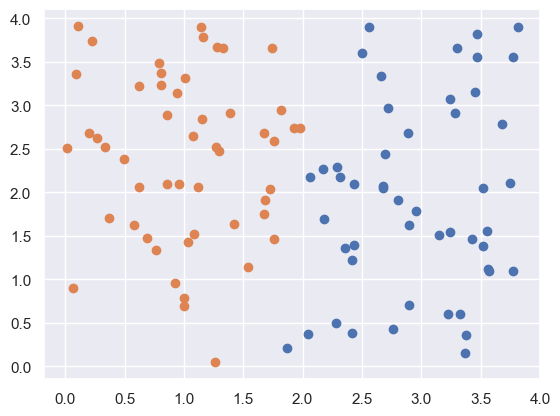

In [4]:
plt.scatter(X_train[y_train.reshape(-1,)==1,0], X_train[y_train.reshape(-1,)==1,1])
plt.scatter(X_train[y_train.reshape(-1,)==-1,0], X_train[y_train.reshape(-1,)==-1,1])

## Define SVM problem and solve it with CVXOPT
Soft-margin formulation of the problem

In [14]:
C = 10
X_dash = y_train * X_train
H = np.dot(X_dash , X_dash.T)
m,n = X_train.shape
y_train = y_train.reshape(-1,1) * 1.


Q = cvxopt_matrix(H)
p = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y_train.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(Q, p, G, h, A, b)
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -9.5739e+01 -5.5915e+03  1e+04  6e-01  8e-14
 1:  2.3862e+00 -1.1826e+03  2e+03  6e-02  8e-14
 2:  2.2755e+01 -1.8714e+02  3e+02  7e-03  6e-14
 3: -6.3958e+00 -6.8582e+01  7e+01  1e-03  4e-14
 4: -1.8422e+01 -4.8359e+01  3e+01  6e-04  4e-14
 5: -2.4257e+01 -3.8936e+01  2e+01  2e-04  5e-14
 6: -2.8425e+01 -3.2599e+01  4e+00  2e-06  4e-14
 7: -3.0496e+01 -3.0822e+01  3e-01  1e-07  4e-14
 8: -3.0667e+01 -3.0672e+01  6e-03  2e-09  5e-14
 9: -3.0670e+01 -3.0670e+01  4e-04  6e-11  5e-14
10: -3.0670e+01 -3.0670e+01  4e-06  6e-13  4e-14
Optimal solution found.


In [15]:
# Extract parameters w and b
w = ((y_train * alphas).T @ X_train).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y_train[S] - np.dot(X_train[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])


Alphas =  [1.35998436 0.11541512 9.99999994 9.99999999 9.99999994 9.99999983
 1.47540408]
w =  [ 4.87068575 -0.91544156]
b =  [-7.89383141]


In [17]:
# Train a linear SVM using sklearn for comparison

clf = SVC(C = 10, kernel = 'linear')
clf.fit(X_train, y_train.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)

w =  [[ 4.86901769 -0.91539757]]
b =  [-7.8904275]


## Evaluate model
On test set

In [22]:
print("************ Accuracy *****************")
(np.sign(np.matmul(X_test, w) + b[0]) == y_test).sum() / y_test.shape[0]

************ Accuracy *****************


0.9788888888888889

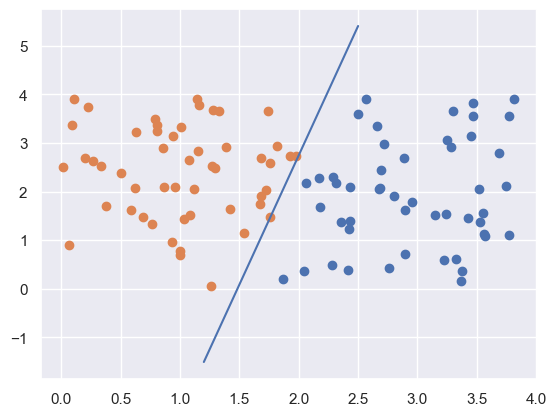

In [23]:
# Plot separation surface
plt.scatter(X_train[y_train.reshape(-1,)==1,0], X_train[y_train.reshape(-1,)==1,1])
plt.scatter(X_train[y_train.reshape(-1,)==-1,0], X_train[y_train.reshape(-1,)==-1,1])
plt.plot(np.linspace(1.2,2.5), np.linspace(1.2,2.5) * (-w[0]/w[1]) + b[0])